In [26]:
# Load libraries
import pandas as pd
import pandas.api.types
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Load data
data = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Midterm/train.csv")
data_test = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Midterm/test.csv")

# Data Preprocessing 

In [4]:
# Examine data
print(data.shape)
print(data_test.shape)
data.head()

(28800, 60)
(3, 58)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


Since there are so many NaNs, we will replace the missing data.

In [5]:
# Replace missing data

# Check missing values
print(f"Number of rows with NaN in Train: {data.isnull().any(axis=1).sum()}")

# Fill numerical variables with median
for col in data.select_dtypes(include=['number']).columns:  
    data[col].fillna(data[col].median(), inplace=True)

# Fill categorical variables with mode
for col in data.select_dtypes(include=['object']).columns:  
    data[col].fillna(data[col].mode()[0], inplace=True)
    
# Check NaNs are removed
print(f"Number of rows with NaN in Train now: {data.isnull().any(axis=1).sum()}")

# Do the same preprocessing for test set
print(f"Number of rows with NaN in Test: {data_test.isnull().any(axis=1).sum()}")

for col in data_test.select_dtypes(include=['number']).columns:  
    data_test[col].fillna(data_test[col].median(), inplace=True)

for col in data_test.select_dtypes(include=['object']).columns:  
    data_test[col].fillna(data_test[col].mode()[0], inplace=True)
    
print(f"Number of rows with NaN in Test now: {data_test.isnull().any(axis=1).sum()}")

Number of rows with NaN in Train: 26826
Number of rows with NaN in Train now: 0
Number of rows with NaN in Test: 2
Number of rows with NaN in Test now: 0


In [8]:
# Remove ID - unnecessary variable
data.drop(columns=['ID'], inplace=True)

# Identify numerical features
num_cols = data.select_dtypes(include=['number']).columns
num_cols = [col for col in num_cols if col not in ['efs', 'efs_time']]

# Standardize numerical features
stadardize = StandardScaler()
data[num_cols] = stadardize.fit_transform(data[num_cols])

In [9]:
# Define a function to calculate the survival rate
def transform_survival_rate(df, time='efs_time', event='efs'):
    """
    Transform the efs and efs_time data into survival rates using the Kaplan-Meier estimator.
    """
    kmf = KaplanMeierFitter()  # initalize estimator
    kmf.fit(df[time], df[event])  # fit the estimator
    survival_prob = kmf.survival_function_at_times(df[time]).to_numpy().flatten()  # calculate probabilites
    df["survival_rate"] = survival_prob  # add probabilities as new variable   
    return df

# Adding survival rate and risk score, the response variable
data = transform_survival_rate(data, "efs_time", "efs")
data['risk_score'] = np.log(data['survival_rate'] / (1 - data['survival_rate']))

data.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,survival_rate,risk_score
0,N/A - non-malignant indication,No,Poor,No,0.488048,0.610215,No TBI,No,0.649549,Bone marrow,...,"N/A, Mel not given",0.635255,No,0.583426,No,0.617168,0.0,42.356,0.458687,-0.165630
1,Intermediate,No,Intermediate,No,0.488048,0.610215,"TBI +- Other, >cGy",No,0.649549,Peripheral blood,...,"N/A, Mel not given",0.635255,No,0.583426,Yes,0.617168,1.0,4.672,0.847759,1.717134
2,N/A - non-malignant indication,No,Poor,No,0.488048,0.610215,No TBI,No,0.649549,Bone marrow,...,"N/A, Mel not given",0.635255,No,0.583426,No,0.617168,0.0,19.793,0.462424,-0.150587
3,High,No,Intermediate,No,0.488048,0.610215,No TBI,No,0.649549,Bone marrow,...,"N/A, Mel not given",0.635255,No,0.583426,No,0.617168,0.0,102.349,0.456661,-0.173792
4,High,No,Poor,No,0.488048,0.610215,No TBI,No,0.649549,Peripheral blood,...,MEL,0.635255,No,0.583426,No,0.617168,0.0,16.223,0.464674,-0.141542


In [17]:
# Identify categorical features
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print("Number of categorical features:", len(cat_cols))

# One-hot encoding
fixed_data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
print("Number of columns after one-hot encoding", len(fixed_data.columns))

# Repeat for test set
test_cat_col = data_test.select_dtypes(include=['object']).columns.tolist()
fixed_data_test = pd.get_dummies(data_test, columns=test_cat_col, drop_first=True)
print("Number of columns after one-hot encoding", len(fixed_data_test.columns))

Number of categorical features: 35
Number of columns after one-hot encoding 152
Number of columns after one-hot encoding 37


In [18]:
# Kaggle given function for stratified C-index to evaluate model performance
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
         if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

# Function to prepare model results into a form accepted by score()
def strat_c_index(y_pred, data):
    """ 
    The score() function takes in the dataframes solution and submission and returns the C-index stratified on race. 
    """
    id_col_name = 'ID'
    
    # submission dataframe
    y_pred = {'prediction': y_pred}
    y_pred = pd.DataFrame(y_pred)
    y_pred.insert(0, id_col_name, range(len(y_pred)))
    
    # solution dataframe
    y_true = data[['efs', 'efs_time', 'race_group']].copy()
    y_true = pd.DataFrame(y_true)
    y_true.insert(0, id_col_name, range(len(y_true)))
    
    # drop index in case of misalignment from merging data in score()
    y_true = y_true.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)
    
    # call score() to get stratified C-index
    index = score(y_true, y_pred, id_col_name)
    
    return index

In [19]:
# Identify features (X) and response (y) variables 
X = fixed_data.drop(columns=['efs_time', 'efs', 'survival_rate', 'risk_score'])
y = fixed_data['risk_score']

# Split into 70-30 train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

# Method 1: Lasso

In [30]:
# Create a function for Lasso 
def lasso(X, y, k, data):
    """"
    This function finds the best lasso model based on K-fold cross validation.
    
    X: features data
    y: response variable
    k: number of folds for cross validation
    data: original cleaned data for stratified C-index calculations
    """
    # Start timer
    start_time = time.time()  

    # Grid search tuning to find best lambda using cross validation
    grid = 10 ** np.linspace(-4, 4, num=100)
    
    print("Training Lasso model with", k, "cross-validation...")
    
    lasso = LassoCV(alphas=grid, cv=k)
    lasso.fit(X, y)
    best_lambda = lasso.alpha_
    print(f"Best lambda: {best_lambda}")
    
    # Get best Lasso model
    best_lasso = Lasso(alpha=best_lambda)
    best_lasso.fit(X, y)
    
    # Make predictions
    y_predicts = lasso.predict(X)

    # Calculate MSE of predictions
    mse = mean_squared_error(y, y_predicts)
    print(f"MSE: {mse}")
    
    # Calculate stratified C-index
    c = strat_c_index(y_predicts, data)
    
    # End timer
    end_time = time.time()  
    elapsed_time = end_time - start_time 
    print(f"Time taken: {elapsed_time:.2f} seconds") 
    
    return y_predicts, mse, c, best_lasso

In [31]:
# Test different K-fold CV 
y_pred_lasso_3, mse_lasso_3, c_lasso_3, best_lasso_3 = lasso(X, y, 3, data)
y_pred_lasso_5, mse_lasso_5, c_lasso_5, best_lasso_5 = lasso(X, y, 5, data)
y_pred_lasso_10, mse_lasso_10, c_lasso_10, best_lasso_10 = lasso(X, y, 10, data)

Training Lasso model with 3 cross-validation...
Best lambda: 0.0005336699231206312
MSE: 1.0757687315223627
Time taken: 10.58 seconds
Training Lasso model with 5 cross-validation...
Best lambda: 0.00021049041445120198
MSE: 1.0734495796282872
Time taken: 12.19 seconds
Training Lasso model with 10 cross-validation...
Best lambda: 0.00021049041445120198
MSE: 1.0734495796282872
Time taken: 14.66 seconds


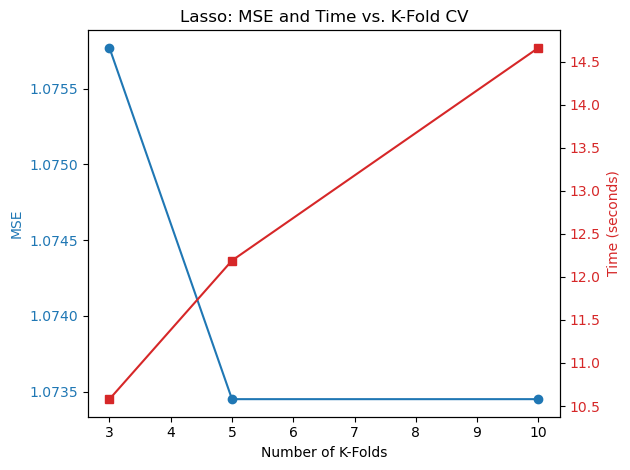

In [35]:
# Combine data from Lasso 
k_folds = [3, 5, 10]
mse_values = [1.0757687315223627, 1.0734495796282872, 1.0734495796282872]
time_taken = [10.58, 12.19, 14.66]

fig, ax1 = plt.subplots()

# Plot MSE on the left y-axis
ax1.set_xlabel("Number of K-Folds")
ax1.set_ylabel("MSE", color="tab:blue")
ax1.plot(k_folds, mse_values, marker="o", color="tab:blue", label="MSE")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create a second y-axis for time taken
ax2 = ax1.twinx()
ax2.set_ylabel("Time (seconds)", color="tab:red")
ax2.plot(k_folds, time_taken, marker="s", color="tab:red", label="Time Taken")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title and layout adjustments
plt.title("Lasso: MSE and Time vs. K-Fold CV")
fig.tight_layout()
plt.show()

In [156]:
# Plot lambda vs MSE for training and test sets
mse_train_lasso = []
mse_test_lasso = []

# Loop through the grid of alphas to compute MSE for each value of alpha
grid = 10 ** np.linspace(-4, 4, num=100)  
for alpha in grid:
    lasso = LassoCV(alphas=[alpha], cv=5)
    lasso.fit(X_train, y_train)
    y_train_pred_lasso = lasso.predict(X_train)
    y_test_pred_lasso = lasso.predict(X_test)
    
    mse_train_lasso.append(mean_squared_error(y_train, y_train_pred_lasso))
    mse_test_lasso.append(mean_squared_error(y_test, y_test_pred_lasso))

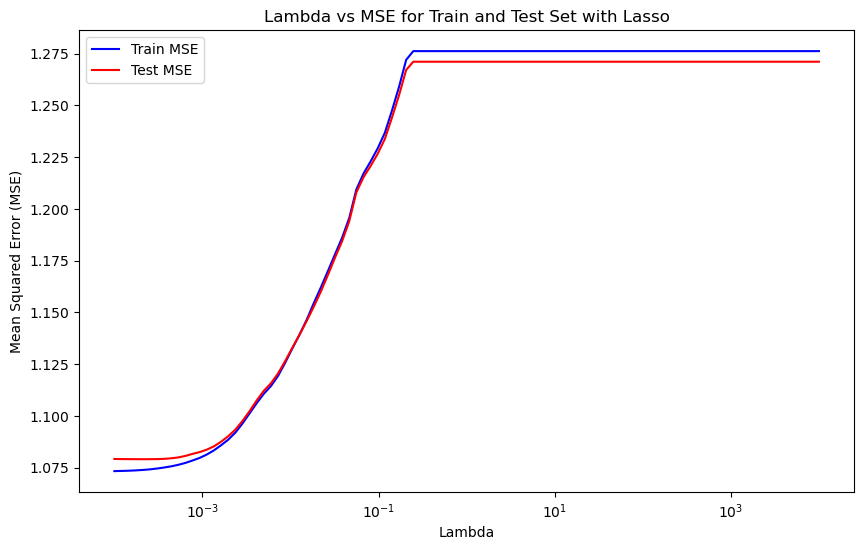

In [161]:
# Plot MSE vs lambda for Lasso
plt.figure(figsize=(10, 6))
plt.plot(grid, mse_train_lasso, label="Train MSE", color='blue')
plt.plot(grid, mse_test_lasso, label="Test MSE", color='red')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lambda vs MSE for Train and Test Set with Lasso')
plt.legend()
plt.show()

# Method 2: Ridge Regression

In [36]:
# Create a function for Ridge Regression
def ridge(X, y, k, data):
    """"
    This function finds the best ridge regression model based on K-fold cross validation.
    
    X: features data
    y: response variable
    k: number of folds for cross validation
    data: original cleaned data for stratified C-index calculations
    """
    # Start timer
    start_time = time.time()  
    
    # Grid search tuning to find best lambda using cross-validation
    grid = 10 ** np.linspace(-4, 4, num=100)  
    
    print("Training Ridge model with", k, "cross-validation...")
    
    ridge = RidgeCV(alphas=grid, cv=5)
    ridge.fit(X, y)
    best_lambda = ridge.alpha_
    print(f"Best lambda: {best_lambda}")
    
    # Get best Ridge model
    best_ridge = Ridge(alpha=best_lambda)
    best_ridge.fit(X, y)
    
    # Make predictions
    y_predicts = best_ridge.predict(X)

    # Calculate MSE of predictions
    mse = mean_squared_error(y, y_predicts)
    print(f"MSE: {mse}")
    
    # Calculate stratified C-index
    c = strat_c_index(y_predicts, data)
    
    # End timer
    end_time = time.time()  
    elapsed_time = end_time - start_time 
    print(f"Time taken: {elapsed_time:.2f} seconds") 
    
    return y_predicts, mse, c, best_ridge

In [37]:
# Test different K-folds CV
y_pred_ridge_3, mse_ridge_3, c_ridge_3, best_ridge_3 = ridge(X, y, 3, data)
y_pred_ridge_5, mse_ridge_5, c_ridge_5, best_ridge_5 = ridge(X, y, 5, data)
y_pred_ridge_10, mse_ridge_10, c_ridge_10, best_ridge_10 = ridge(X, y, 10, data)

Training Ridge model with 3 cross-validation...
Best lambda: 21.544346900318867
MSE: 1.0731796060290497
Time taken: 117.23 seconds
Training Ridge model with 5 cross-validation...
Best lambda: 21.544346900318867
MSE: 1.0731796060290497
Time taken: 118.18 seconds
Training Ridge model with 10 cross-validation...
Best lambda: 21.544346900318867
MSE: 1.0731796060290497
Time taken: 114.10 seconds


In [ ]:
# Combine data from Ridge 
k_folds = [3, 5, 10]
mse_values = [1.0757687315223627, 1.0734495796282872, 1.0734495796282872]
time_taken = [10.58, 12.19, 14.66]

fig, ax1 = plt.subplots()

# Plot MSE on the left y-axis
ax1.set_xlabel("Number of K-Folds")
ax1.set_ylabel("MSE", color="tab:blue")
ax1.plot(k_folds, mse_values, marker="o", color="tab:blue", label="MSE")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create a second y-axis for time taken
ax2 = ax1.twinx()
ax2.set_ylabel("Time (seconds)", color="tab:red")
ax2.plot(k_folds, time_taken, marker="s", color="tab:red", label="Time Taken")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title and layout adjustments
plt.title("Ridge Regression: MSE and Time vs. K-Fold CV")
fig.tight_layout()
plt.show()

In [138]:
# Run Ridge Reg
train_y_pred_ridge, train_mse_ridge, train_ridge = ridge(X, y)

# Calculate stratified C-index
strat_c_index(train_y_pred_ridge, data)

Training Ridge model with cross-validation...
Best lambda: 21.544346900318867
MSE: 1.0731796060290497


0.6448677479735924

In [155]:
# Plot lambda vs MSE for training and test sets
mse_train_ridge = []
mse_test_ridge = []

# Loop through the grid of alphas to compute MSE for each value of alpha
grid = 10 ** np.linspace(-4, 4, num=100)  
for alpha in grid:
    ridge = RidgeCV(alphas=[alpha], cv=5)
    ridge.fit(X_train, y_train)
    y_train_pred_ridge = ridge.predict(X_train)
    y_test_pred_ridge = ridge.predict(X_test)
    
    mse_train_ridge.append(mean_squared_error(y_train, y_train_pred_ridge))
    mse_test_ridge.append(mean_squared_error(y_test, y_test_pred_ridge))

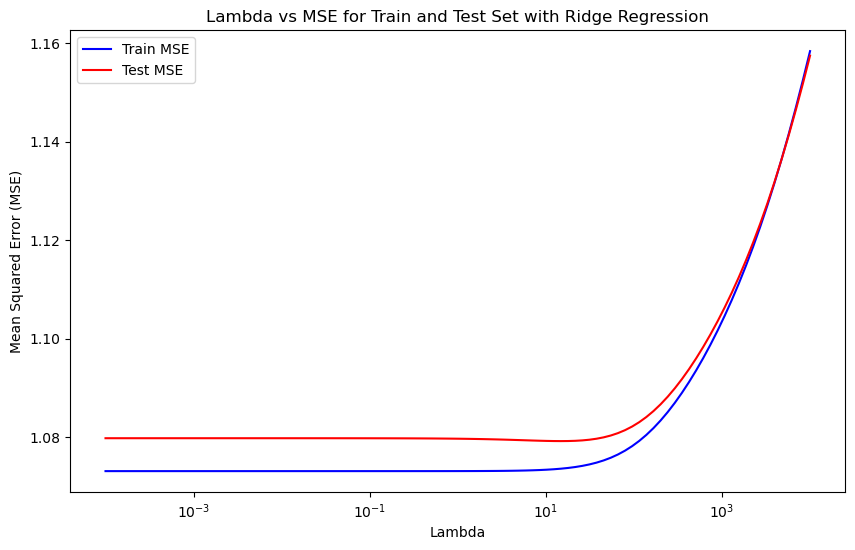

In [162]:
# Plot MSE vs lambda for Ridge
plt.figure(figsize=(10, 6))
plt.plot(grid, mse_train_ridge, label="Train MSE", color='blue')
plt.plot(grid, mse_test_ridge, label="Test MSE", color='red')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lambda vs MSE for Train and Test Set with Ridge Regression')
plt.legend()
plt.show()

In [143]:
num_zero_lasso = np.sum(train_lasso.coef_ == 0)
num_nonzero_ridge = np.sum(train_ridge.coef_ != 0)

print(f"Lasso zero coefficients: {num_nonzero_lasso}")
print(f"Ridge non-zero coefficients: {num_nonzero_ridge}")


Lasso zero coefficients: 19
Ridge non-zero coefficients: -0.8563367171855556


# Method 3: XGBoost

In [6]:
def xgboost(train_df):
    features = [col for col in train_df.columns if col not in ['efs_time', 'efs', 'survival_prob', 'risk_score']]
    X = train_df[features]
    y = train_df['risk_score']
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=200),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        }
        model = XGBRegressor(**params, objective='reg:pseudohubererror')
        model.fit(X, y)
        preds = model.predict(X)
        return concordance_index(y, preds)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)

    xgb_model = XGBRegressor(**study.best_params, objective='reg:pseudohubererror')
    xgb_model.fit(X, y)
    train_predictions = xgb_model.predict(X)
    
    #test_data = align_features(train_df[features], test_df[features])
    #xgb_risk_scores = xgb_model.predict(test_data)

    return xgb_model, train_predictions

In [22]:
xgb_model, train_pred_xgb = xgboost(fixed_data)

[I 2025-03-07 17:20:01,774] A new study created in memory with name: no-name-ad231a4d-9793-4563-b536-189c9cba1a6f
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[W 2025-03-07 17:20:01,898] Trial 0 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.011090180153418238, 'max_depth': 10, 'subsample': 0.688840091678626, 'colsample_bytree': 0.5570058008922991} because of the following error: ValueError('feature_names must be string, and may not contain [, ] or <').
Traceback (most recent call last):
  File "C:\Users\ashle\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ashle\AppData\Local\Temp\ipykernel_24828\3412818230.py", line 15, in objective
    model.fit(X, y)
  File "C:\Users\ashle\anaconda3\lib\site-p

ValueError: feature_names must be string, and may not contain [, ] or <

In [ ]:
def train_XGB(train, test, model_params, features, target):
    fix_params = {
        'tree_method': 'hist',
        'device': 'cuda', 
        'objective': 'reg:squarederror',
        'n_estimators': 10000,
        'early_stopping_rounds': 20,
        'eval_metric': 'rmse',
        'enable_categorical': True
    }
    model_params.update(fix_params)

    FOLDS = 10
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    oof_xgb = np.zeros(len(train))
    pred_xgb = np.zeros(len(test))

    print('Training XGBoost model with the following parameters:')
    for k, v in model_params.items():
        print(f'{k} : {v}')

    for i, (t_idx, v_idx) in enumerate(kf.split(train)):
        X_train = train.iloc[t_idx][features].copy()
        y_train = train.iloc[t_idx][target]
        X_valid = train.iloc[v_idx][features].copy()
        y_valid = train.iloc[v_idx][target]
        X_test = test[features].copy()
        
        model_xgb = XGBRegressor(**model_params)
        model_xgb.fit(
            X_train, np.log1p(y_train),
            eval_set=[(X_valid, np.log1p(y_valid))],
            verbose=False
        )

        y_valid_preds = np.expm1(model_xgb.predict(X_valid))
        oof_xgb[v_idx] = y_valid_preds
        pred_xgb += np.expm1(model_xgb.predict(X_test))

        fold_rmse = mean_squared_error(y_valid, y_valid_preds, squared=False)
        print("#" * 25)
        print(f"### Fold {i+1} \n")
        print(f"Fold {i+1} RMSE: {fold_rmse}")
        print("#" * 25)

    pred_xgb /= FOLDS

    return model_xgb, oof_xgb, pred_xgb

# Method 4: Cox Regression

# Plots

In [ ]:
# Create a plot comparing predicted risk scores across the race groups